 Step 1: Install libraries

In [4]:
%pip install --quiet scikit-learn joblib matplotlib pandas seaborn


Step2:Imports and helper setup

In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import joblib
from google.colab import files


%matplotlib inline
sns.set(style="whitegrid")


Step 3:Generate a synthetic dataset (patient_vitals.csv)

In [6]:
# Cell 3 — dataset generator (runs quickly)
np.random.seed(42)
random.seed(42)

n_patients = 500
records_per_patient = 20
rows = []
start_time = datetime.now()

for pid in range(1, n_patients+1):
    age = np.random.randint(18, 90)
    base_hr = np.random.normal(75, 7)
    base_sys = np.random.normal(120, 8)
    base_dia = np.random.normal(78, 6)
    base_rr = np.random.normal(16, 2)
    base_spo2 = np.random.normal(97, 1)
    base_temp = np.random.normal(36.7, 0.25)

    deteriorate = np.random.rand() < 0.25
    det_start = np.random.randint(0, records_per_patient) if deteriorate else None

    for i in range(records_per_patient):
        ts = start_time + timedelta(minutes=30 * i) + timedelta(days=random.randint(0,30))
        hr = np.random.normal(base_hr, 5)
        sys = np.random.normal(base_sys, 6)
        dia = np.random.normal(base_dia, 4)
        rr = np.random.normal(base_rr, 1.5)
        spo2 = np.random.normal(base_spo2, 0.8)
        temp = np.random.normal(base_temp, 0.2)

        label = 0
        if deteriorate and i >= det_start:
            hr += np.random.normal(20, 6)
            sys -= np.random.normal(20, 8)
            dia -= np.random.normal(10, 4)
            rr += np.random.normal(6, 2)
            spo2 -= np.random.normal(5, 1.5)
            temp += np.random.normal(1.0, 0.4)
            prob_det = 0.6 + 0.4 * np.random.rand()
            label = 1 if np.random.rand() < prob_det else 0

        rows.append({
            "patient_id": pid,
            "timestamp": ts.isoformat(),
            "age": int(age),
            "heart_rate": float(round(hr, 1)),
            "sys_bp": float(round(sys, 1)),
            "dia_bp": float(round(dia, 1)),
            "resp_rate": float(round(rr, 1)),
            "spo2": float(round(spo2, 1)),
            "temp_c": float(round(temp, 2)),
            "label": int(label)
        })

df = pd.DataFrame(rows)
df.to_csv("patient_vitals.csv", index=False)
print("Saved patient_vitals.csv with", len(df), "rows")
df.head()



Saved patient_vitals.csv with 10000 rows


,patient_id,timestamp,age,heart_rate,sys_bp,dia_bp,resp_rate,spo2,temp_c,label
0,1,2025-12-11T15:16:00.522329,69,67.3,120.0,77.5,17.8,96.6,36.42,0
1,1,2025-11-24T15:46:00.522329,69,67.9,122.3,84.2,17.9,96.0,36.95,0
2,1,2025-11-21T16:16:00.522329,69,57.1,129.3,82.8,16.4,97.3,36.64,0
3,1,2025-12-14T16:46:00.522329,69,65.3,115.6,81.9,17.0,95.3,36.50,0
4,1,2025-11-29T17:16:00.522329,69,64.9,123.0,79.0,19.8,97.0,36.53,0


Shape: (10000, 10)

Label distribution:
 label
0    8947
1    1053
Name: count, dtype: int64

Label proportion:
 label
0    0.8947
1    0.1053
Name: proportion, dtype: float64


,count,mean,min,25%,50%,75%,max,std
patient_id,10000.0,250.5,1.0,125.75,250.5,375.25,500.0,144.344496
timestamp,10000,2025-12-06 21:18:20.202329600,2025-11-21 15:16:00.522329,2025-11-29 00:16:00.522329088,2025-12-06 21:46:00.522329088,2025-12-14 16:16:00.522329088,2025-12-22 00:46:00.522329,NaN
age,10000.0,53.418,18.0,34.0,53.0,72.0,89.0,20.901745
heart_rate,10000.0,77.9932,39.8,70.6,77.1,84.2,129.9,11.056009
sys_bp,10000.0,117.99187,66.1,111.1,118.8,126.3,160.2,12.244557
dia_bp,10000.0,77.27993,44.4,72.3,77.7,82.7,105.1,8.17009
resp_rate,10000.0,16.82201,6.8,14.6,16.5,18.6,31.7,3.374671
spo2,10000.0,96.33891,85.7,95.6,96.7,97.7,101.5,2.192318
temp_c,10000.0,36.812686,35.59,36.5,36.72,36.9925,39.49,0.49439
label,10000.0,0.1053,0.0,0.0,0.0,0.0,1.0,0.306955


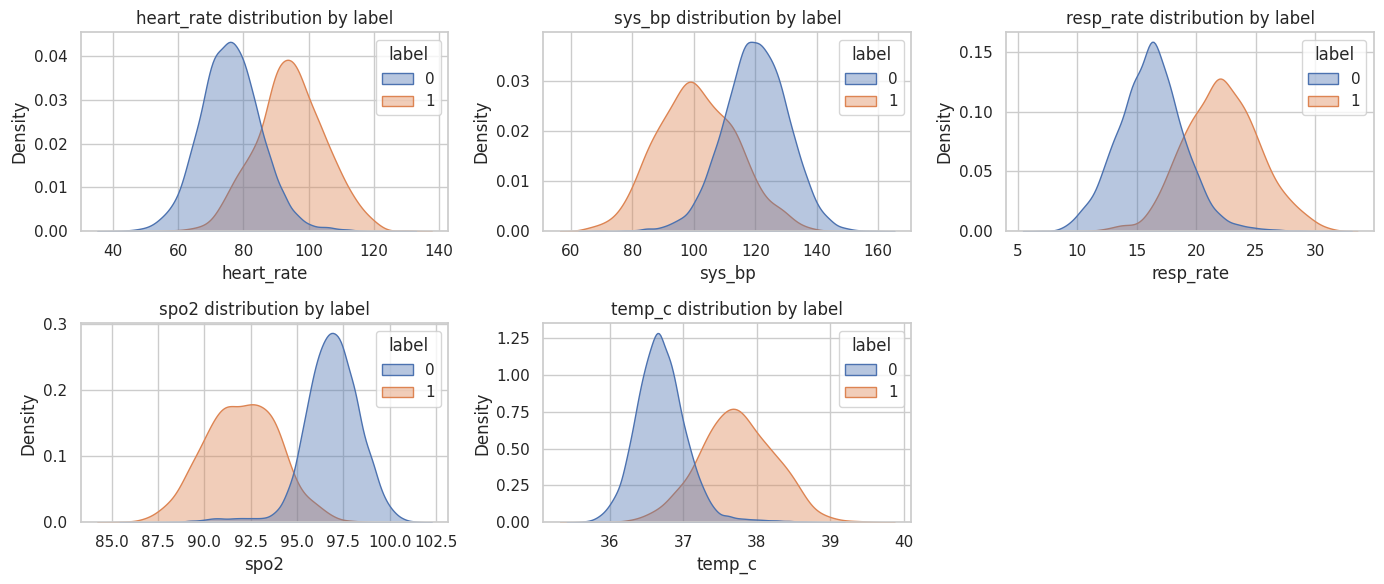

In [7]:
# Cell 4 — EDA
df = pd.read_csv("patient_vitals.csv", parse_dates=["timestamp"])
print("Shape:", df.shape)
print("\nLabel distribution:\n", df['label'].value_counts(normalize=False))
print("\nLabel proportion:\n", df['label'].value_counts(normalize=True))

# show basic stats
display(df.describe().T)

# Plot distributions of some key vitals split by label
plt.figure(figsize=(14,6))
features = ["heart_rate", "sys_bp", "resp_rate", "spo2", "temp_c"]
for i, f in enumerate(features, 1):
    plt.subplot(2,3,i)
    sns.kdeplot(data=df, x=f, hue="label", fill=True, common_norm=False, alpha=0.4)
    plt.title(f"{f} distribution by label")
plt.tight_layout()



Step 5:Preprocessing: impute, scale, split

In [9]:
features = ["age", "heart_rate", "sys_bp", "dia_bp", "resp_rate", "spo2", "temp_c"]
X = df[features].copy()
y = df["label"]

# Impute (median) — safe default for numeric clinical data
imputer = SimpleImputer(strategy="median")
X_imp = pd.DataFrame(imputer.fit_transform(X), columns=features)

# Train/test split (stratified to keep label balance)
X_train, X_test, y_train, y_test = train_test_split(
    X_imp, y, test_size=0.20, stratify=y, random_state=42
)

# Scale (StandardScaler) — helps some models and interpretation
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

print("Shapes — X_train:", X_train_s.shape, "X_test:", X_test_s.shape)
print("Train label counts:\n", y_train.value_counts())


Shapes — X_train: (8000, 7) X_test: (2000, 7)
Train label counts:
 label
0    7158
1     842
Name: count, dtype: int64


Step 6:Train a baseline Random Forest

In [10]:
rf = RandomForestClassifier(n_estimators=150, max_depth=8, random_state=42, class_weight="balanced")
rf.fit(X_train_s, y_train)
print("Model trained.")


Model trained.


Step 7: Evaluate model (classification report, confusion matrix, ROC AUC)

Classification report:
              precision    recall  f1-score   support

           0     0.9966    0.9726    0.9844      1789
           1     0.8071    0.9716    0.8817       211

    accuracy                         0.9725      2000
   macro avg     0.9018    0.9721    0.9331      2000
weighted avg     0.9766    0.9725    0.9736      2000

Confusion matrix:
 [[1740   49]
 [   6  205]]
ROC AUC: 0.9868


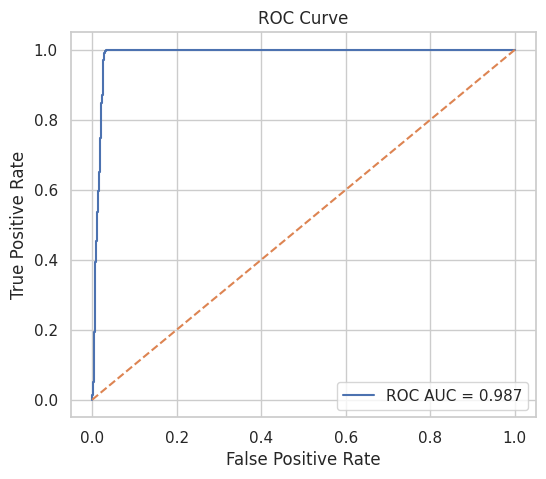

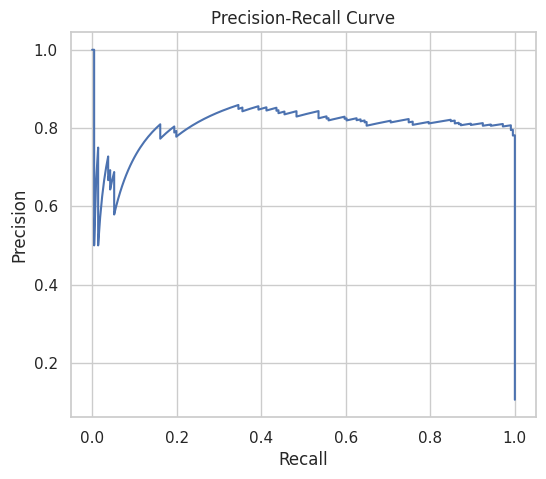

In [11]:
y_pred = rf.predict(X_test_s)
y_proba = rf.predict_proba(X_test_s)[:,1]

print("Classification report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

auc = roc_auc_score(y_test, y_proba)
print("ROC AUC:", round(auc, 4))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC AUC = {auc:.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curve (useful for imbalanced tasks)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


Step 8:Feature importance





In [ ]:
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=True)
plt.figure(figsize=(6,4))
feat_imp.plot(kind="barh")
plt.title("Feature importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
print(feat_imp.sort_values(ascending=False))


Step 9:Save model + preprocessing

In [12]:
artifact = {
    "model": rf,
    "scaler": scaler,
    "imputer": imputer,
    "features": features
}
joblib.dump(artifact, "patient_monitoring_rf.joblib")
print("Saved patient_monitoring_rf.joblib")

files.download("patient_monitoring_rf.joblib")


Saved patient_monitoring_rf.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Step 10 : Prediction helper-how to run inference on new vitals

In [13]:
artifact = joblib.load("patient_monitoring_rf.joblib")
model = artifact["model"]
scaler = artifact["scaler"]
imputer = artifact["imputer"]
features = artifact["features"]

def predict_records(records):
    """
    records: list of dicts or a pandas DataFrame with same feature names
    returns: list of dicts with prediction and probability
    """
    if isinstance(records, dict):
        records = [records]
    df_in = pd.DataFrame(records)
    X = df_in.reindex(columns=features)
    X_imp = pd.DataFrame(imputer.transform(X), columns=features)
    X_s = scaler.transform(X_imp)
    preds = model.predict(X_s)
    probs = model.predict_proba(X_s)[:,1]
    results = []
    for i, row in df_in.iterrows():
        results.append({
            "input": row.to_dict(),
            "prediction": int(preds[i]),
            "probability": float(probs[i])
        })
    return results

example = {"age":70,"heart_rate":120,"sys_bp":85,"dia_bp":50,"resp_rate":28,"spo2":89,"temp_c":38.5}
print("Example input:", example)
print("Prediction result:", predict_records(example))


Example input: {'age': 70, 'heart_rate': 120, 'sys_bp': 85, 'dia_bp': 50, 'resp_rate': 28, 'spo2': 89, 'temp_c': 38.5}
Prediction result: [{'input': {'age': 70.0, 'heart_rate': 120.0, 'sys_bp': 85.0, 'dia_bp': 50.0, 'resp_rate': 28.0, 'spo2': 89.0, 'temp_c': 38.5}, 'prediction': 1, 'probability': 0.9582535402029161}]
